In [63]:
import pandas as pd
import numpy as np
import pickle
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install wordcloud

from sklearn.metrics import accuracy_score,fbeta_score,classification_report
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
stop=stopwords.words("english")

from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
ss = SnowballStemmer("english")
ps = PorterStemmer()

msg_df = pd.read_csv('spam.csv', sep='\t', names=["label", "message"])
msg_df.shape


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(5572, 2)

In [64]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [65]:
msg_df = pd.read_csv('spam.csv', sep='\t', names=["label", "message"])
msg_df.shape
msg_df.head(5)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [66]:
msg_df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [67]:
msg_df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [68]:
msg_df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

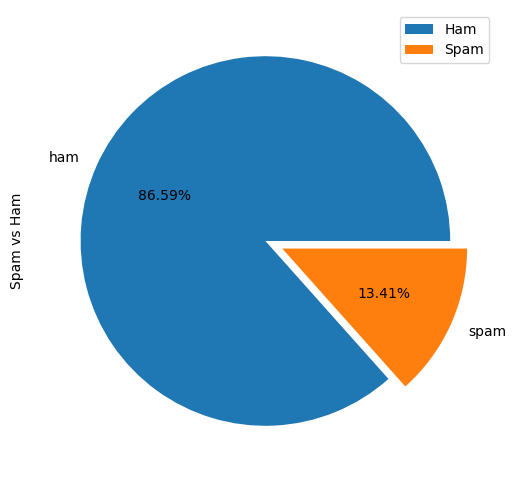

In [69]:
msg_df["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.2f%%')
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [70]:
msg_df.groupby("message")["label"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)

,len,amax
message,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Ok,4,ham
Okie,4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st ""Ur Lovely Friendship""... good morning dear",4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!,4,spam


In [71]:
msg_df['length']=msg_df['message'].apply(len)
msg_df.head()


,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [72]:
msg_df.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [73]:
msg_df[msg_df['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

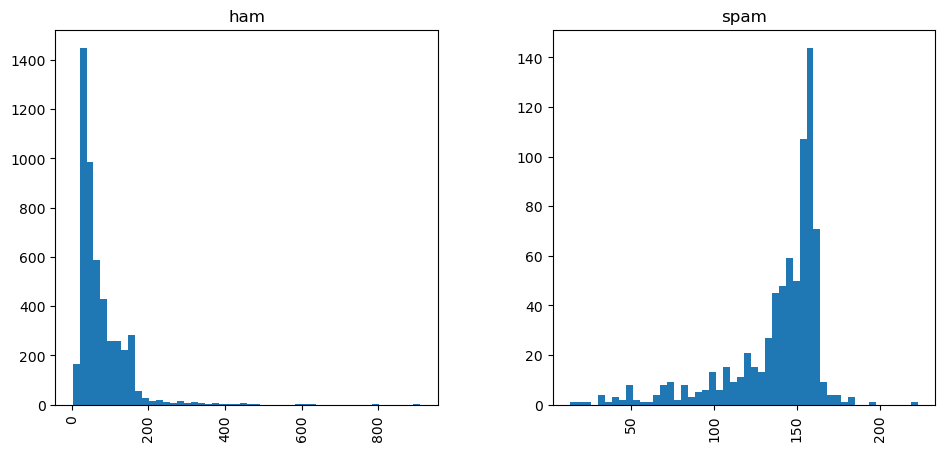

In [74]:
msg_df.hist(column='length', by='label', bins=50,figsize=(11,5))

Looks like the lengthy is the message, more likely it is a spam. Let's not forget this


 # Text Transformation
Data Cleaning (Removing unimportant data/ Stopwords/ Stemming)

In [75]:
msg_df.head(4)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49


In [76]:
import string
def cleanText(message):
    #message = message.translate(str.maketrans('ranjan', 'ranjan', string.punctuation))
    message = re.sub('[^a-zA-Z]', ' ', message)
    message = message.lower()
    message = message.split()
    words = [ss.stem(word) for word in message if word not in stop]
    return " ".join(words)

msg_df["message"] = msg_df["message"].apply(cleanText)
msg_df.head(n = 10)



,label,message,length
0,ham,go jurong point crazi avail bugi n great world...,111
1,ham,ok lar joke wif u oni,29
2,spam,free entri wkli comp win fa cup final tkts st ...,155
3,ham,u dun say earli hor u c alreadi say,49
4,ham,nah think goe usf live around though,61
5,spam,freemsg hey darl week word back like fun still...,147
6,ham,even brother like speak treat like aid patent,77
7,ham,per request mell mell oru minnaminungint nurun...,160
8,spam,winner valu network custom select receivea pri...,157
9,spam,mobil month u r entitl updat latest colour mob...,154


In [77]:
spam_messages = msg_df[msg_df["label"] == "spam"]["message"]
ham_messages = msg_df[msg_df["label"] == "ham"]["message"]

In [78]:
spam_messages

2       free entri wkli comp win fa cup final tkts st ...
5       freemsg hey darl week word back like fun still...
8       winner valu network custom select receivea pri...
9       mobil month u r entitl updat latest colour mob...
11      six chanc win cash pound txt csh send cost p d...
                              ...                        
5537    want explicit sex sec ring cost p min gsex pob...
5540    ask mobil chatlin inclu free min india cust se...
5547    contract mobil mnths latest motorola nokia etc...
5566    remind get pound free call credit detail great...
5567    nd time tri contact u u pound prize claim easi...
Name: message, Length: 747, dtype: object

In [79]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [80]:
spam_words = []
ham_words = []

def extractSpamWords(spamMessages):
    global spam_words
    words = [word for word in word_tokenize(spamMessages)]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word for word in word_tokenize(hamMessages) ]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
        ... 
5565    None
5568    None
5569    None
5570    None
5571    None
Name: message, Length: 4825, dtype: object

In [81]:
ham_words

['go',
 'jurong',
 'point',
 'crazi',
 'avail',
 'bugi',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amor',
 'wat',
 'ok',
 'lar',
 'joke',
 'wif',
 'u',
 'oni',
 'u',
 'dun',
 'say',
 'earli',
 'hor',
 'u',
 'c',
 'alreadi',
 'say',
 'nah',
 'think',
 'goe',
 'usf',
 'live',
 'around',
 'though',
 'even',
 'brother',
 'like',
 'speak',
 'treat',
 'like',
 'aid',
 'patent',
 'per',
 'request',
 'mell',
 'mell',
 'oru',
 'minnaminungint',
 'nurungu',
 'vettam',
 'set',
 'callertun',
 'caller',
 'press',
 'copi',
 'friend',
 'callertun',
 'gon',
 'na',
 'home',
 'soon',
 'want',
 'talk',
 'stuff',
 'anymor',
 'tonight',
 'k',
 'cri',
 'enough',
 'today',
 'search',
 'right',
 'word',
 'thank',
 'breather',
 'promis',
 'wont',
 'take',
 'help',
 'grant',
 'fulfil',
 'promis',
 'wonder',
 'bless',
 'time',
 'date',
 'sunday',
 'oh',
 'k',
 'watch',
 'eh',
 'u',
 'rememb',
 'spell',
 'name',
 'yes',
 'v',
 'naughti',
 'make',
 'v',
 'wet',
 'fine',
 'way',
 'u',
 'f

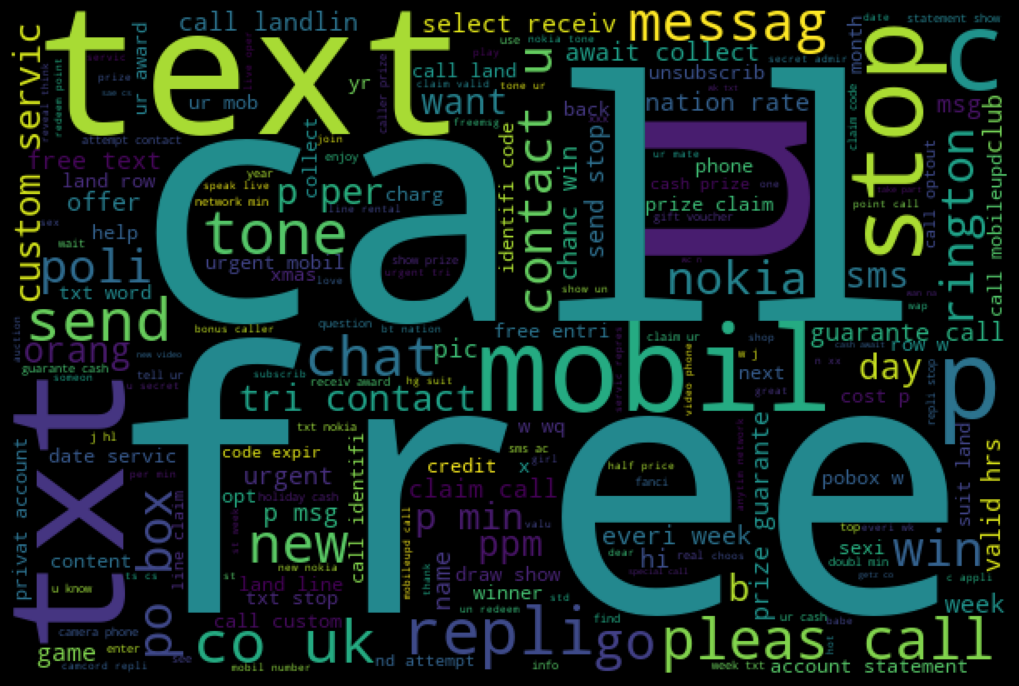

In [82]:
spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

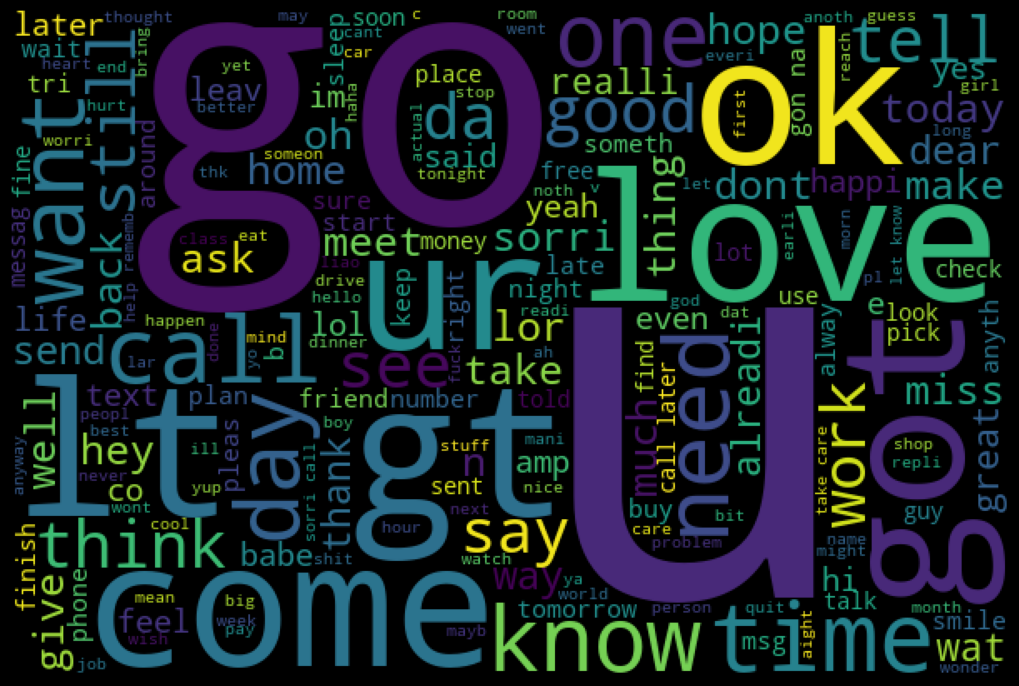

In [83]:
ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [84]:
msg_df

,label,message,length
0,ham,go jurong point crazi avail bugi n great world...,111
1,ham,ok lar joke wif u oni,29
2,spam,free entri wkli comp win fa cup final tkts st ...,155
3,ham,u dun say earli hor u c alreadi say,49
4,ham,nah think goe usf live around though,61
...,...,...,...
5567,spam,nd time tri contact u u pound prize claim easi...,160
5568,ham,b go esplanad fr home,36
5569,ham,piti mood suggest,57
5570,ham,guy bitch act like interest buy someth els nex...,125


In [85]:
def encodeCategory(cat):
    if cat == "spam":
        return 1
    else:
        return 0
        
msg_df["label"] = msg_df["label"].apply(encodeCategory)

In [86]:
msg_df

,label,message,length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri wkli comp win fa cup final tkts st ...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah think goe usf live around though,61
...,...,...,...
5567,1,nd time tri contact u u pound prize claim easi...,160
5568,0,b go esplanad fr home,36
5569,0,piti mood suggest,57
5570,0,guy bitch act like interest buy someth els nex...,125



Lets convert our clean text into a representation that a machine learning model can understand.
Bag of Words
Techiniques are :
#TFIDF
#Count Vectorizer


In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode")
features = vec.fit_transform(msg_df["message"])
print(features.shape)

(5572, 6292)


In [88]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X=cv.fit_transform(msg_df["message"])
print (X.shape)

(5572, 6292)


In [89]:
cv = CountVectorizer()

X=cv.fit(msg_df["message"])
X.vocabulary_
X.get_feature_names()

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'aah',
 'aaniy',
 'aaooooright',
 'aathi',
 'ab',
 'abbey',
 'abdomen',
 'abeg',
 'abel',
 'aberdeen',
 'abi',
 'abil',
 'abiola',
 'abj',
 'abl',
 'abnorm',
 'abouta',
 'abroad',
 'absenc',
 'absolut',
 'abstract',
 'abt',
 'abta',
 'aburo',
 'abus',
 'ac',
 'academ',
 'acc',
 'accent',
 'accentur',
 'accept',
 'access',
 'accid',
 'accident',
 'accommod',
 'accommodationvouch',
 'accomod',
 'accord',
 'accordin',
 'account',
 'accumul',
 'ach',
 'achan',
 'achiev',
 'acid',
 'acknowledg',
 'acl',
 'acnt',
 'aco',
 'across',
 'act',
 'actin',
 'action',
 'activ',
 'actor',
 'actual',
 'ad',
 'adam',
 'add',
 'addamsfa',
 'addi',
 'addict',
 'address',
 'adewal',
 'adi',
 'adjust',
 'admin',
 'administr',
 'admir',
 'admiss',
 'admit',
 'ador',
 'adp',
 'adress',
 'adrian',
 'adrink',
 'adsens',
 'adult',
 'advanc',
 'adventur',
 'advic',
 'advis',
 'advisor',
 'ae',
 'aeronaut',
 'aeroplan',
 'afew',
 'affair',
 'affect',
 'affection',
 'affidavit',
 'afford',
 'afghanistan',


In [90]:
X = cv.fit_transform(msg_df["message"]).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [91]:
df = pd.DataFrame(X,columns=cv.get_feature_names())
df
df['len']=msg_df['length']
df

,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada,len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,111
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,155
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,160
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,57
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,125


In [92]:
df

,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada,len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,111
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,155
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,160
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,57
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,125


In [93]:
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [94]:
df.head()

,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada,len
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,111
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,155
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,61


In [95]:
y=msg_df['label']

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.20, random_state = 0)

# Training model using Naive bayes classifier

from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(X_train, y_train)

y_pred=spam_detect_model.predict(X_test)

In [97]:
print(accuracy_score(y_test,y_pred))
print(fbeta_score(y_test,y_pred,beta =0.5))


0.9811659192825112
0.9390862944162438


In [98]:
y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [99]:
print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       955
           1       0.94      0.93      0.93       160

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [100]:
saved_model=pickle.dumps(spam_detect_model)

In [101]:
modelfrom_pickle = pickle.loads(saved_model) 

In [102]:
y_pred=modelfrom_pickle.predict(X_test)

In [103]:
print(accuracy_score(y_test,y_pred))

0.9811659192825112


In [104]:
import joblib

In [105]:
joblib.dump(spam_detect_model,'pickle.pkl')

['pickle.pkl']

In [106]:
joblib.dump(X,'transform.pkl')

['transform.pkl']